# Import .mod file to numpy

---
Tobias Stål, 2020

A type of text files that contain multidimensional data are grouped in blocks, with each block header containing coordinates, and then follow a 2D dataset (rows and columns), that ends at next block header. Such file format might be suaitable for software as [MINEOS](https://geodynamics.org/cig/software/), but can be challanging to import to a Python environment. 

Here I show how a mod file, containing SL2013sv tomographic model [Schaeffer and Lebedev, 2013](https://academic.oup.com/gji/article/194/1/417/645133), can be imported to a numpy array and saved in netCDF format. The code can easily be modified for similar file formats. 

The file converted here is 2.18Gb. More information and link to download dataset here:
https://schaeffer.ca/tomography/sl2013sv/#ModelDownloads

We start by imprting standard Python package. Re is the Python [regex](https://en.wikipedia.org/wiki/Regular_expression) package to parse the files. [xarray](https://doi.org/10.5334/jors.148) is a very powerful package to deal with labelled multidmiensional arrays and also provide handy methods to save and plot data. 


In [18]:
import numpy as np
import re
from matplotlib import pyplot as plt

# 'xarray is used only to save result to netCDF. Highly recomended package.'
try:
    import xarray as xr 
except:
    pass

# multiprocessing will speed up the parsing function
try:
    import multiprocessing as mp
except:
    pass

Reading the file is fairly quick, even as it is large, it is the parsing of text that will take time. 

In [2]:
mod_file = '../data/SL2013sv_1D_0.5D/SL2013sv.VpVs.dd.mod'

with open(mod_file, 'r') as f:
    lines = f.readlines()

# Get starting ID for all 1D profiles
profile_starts = [i for i, l in enumerate(lines) if l.startswith('>')]

# Add index for last row
profile_starts = profile_starts + [len(lines)]

This is the slow steps. I've been experimenting with numpy functions ([loadtext](https://numpy.org/doc/stable/reference/generated/numpy.loadtxt.html?highlight=loadtxt#numpy.loadtxt), [fromregex](https://numpy.org/doc/stable/reference/generated/numpy.fromregex.html?highlight=fromregex#numpy.fromregex) and [genfromtxt](https://numpy.org/doc/stable/reference/generated/numpy.genfromtxt.html#numpy.genfromtxt)) but it turned out that the import was slower and just as complicated. The issue is that the blocks have different lenght. There might be better options, but this appears to work, however. 

In [19]:
# Reduce the computational cost by excluding layers safely outside the modelled space
never_used_low = 75
never_used_top = 8

# The profiles have different lenght, check max lengh
max_depths = max(x[0] - x[1] for x in zip(profile_starts[1:], profile_starts))

n_profiles = len(profile_starts)

# Make array to store the blocks
# (N of profiles (- last), used depth sections, data coluns + coordinates
data = np.zeros((n_profiles-1, max_depths-never_used_low-never_used_top, 7))

print('maximum number of depth points:', max_depths, 
     'number of profiles: ', n_profiles,
      'last profile id:', profile_starts[-1], 
     'shape of import array:', np.shape(data), sep='\n')

# Loop all the profles and exatract the lines until next profile start, 
# excluding lines safely outside model range

for i in range(n_profiles-1):
    start = profile_starts[i]
    end = profile_starts[i+1]
    coord = re.findall(r"[-+]?\d*\.\d+|\d+", lines[start])[-2:] # Extract lat lon from comment liines
    data_strs = lines[start+1+never_used_low:end-1-never_used_top] # Define what rows to import
    block = np.array([re.findall(r"[-+]?\d*\.\d+|\d+", l) for l in data_strs]) # Extract lines as lists of float
    block_lines = np.shape(block)[0] # Actual number of lines in block
    data[i, :block_lines, :5] = block # Save data to col 1-5
    data[i, :block_lines, 5:] = coord # Broadcast coordinates to each line
    

maximum number of depth points:
204
number of profiles: 
260282
last profile id:
50648197
shape of import array:
(260281, 121, 7)


A quick look at the perturbation profiles gives a plausable result. Note that the perturbation is padded with zeros, and for the selected profiles `never_used_low` and `never_used_top` don't exclude all padding. 

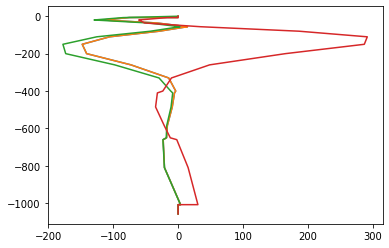

In [4]:
examples = [2, 200, 2000, 20000]
for example in examples:
    plt.plot(data[example, :, 3], -data[example, :, 4])

In [5]:
# We can confirm that we actually read a few extra layers
keep_layers = np.sum(data[:, :, 3], axis=0) != 0
print('layers that only contains 0:',sum(~keep_layers),'/', len(keep_layers))

# Are there any empty records?
empty_index = np.where( np.sum(data, axis=(1,2))==0)
print('empty records:', empty_index)
# Good. 

layers that only contains 0: 12 / 121
empty records: (array([], dtype=int64),)


In [6]:
# Remove 1D models and calculate actual wavespeed 
# 0 S wave speed
# 1 P wave speed
# 2 Depth
# 3 Lat
# 4 Lon

ws = np.array([data[:, :, 0] + data[:, :, 1]/1000, 
                data[:, :, 2] + data[:, :, 3]/1000, 
                data[:, :, 4],
                data[:, :, 5],
                data[:, :, 6]])

print(np.shape(ws))

(5, 260281, 121)


In [7]:
res = (0.5, 0.5)
y_index = ((ws[3,:,:]/res[0])+np.ptp(ws[3,:,:])).astype('int')
x_index = ((ws[4,:,:]/res[0])+np.ptp(ws[4,:,:])).astype('int')

shape_grid = (np.ptp(y_index)+1, np.ptp(x_index)+1, np.shape(ws)[2],3)

grid = np.zeros(shape_grid)

print(np.shape(grid))

(361, 721, 121, 3)


In [8]:
for i in range(np.shape(ws)[1]):
    x = x_index[i,0]
    y = y_index[i,0]    
    grid[y,x,:,0] = ws[0,i,:] # s
    grid[y,x,:,1] = ws[1,i,:] # p
    grid[y,x,:,2] = ws[2,i,:]  #depth
    

We read coordinates and check if they agree with provided list. 

In [9]:
lats = np.unique(ws[3,:,:])
lons = np.unique(ws[4,:,:])

Consistant depths: 65


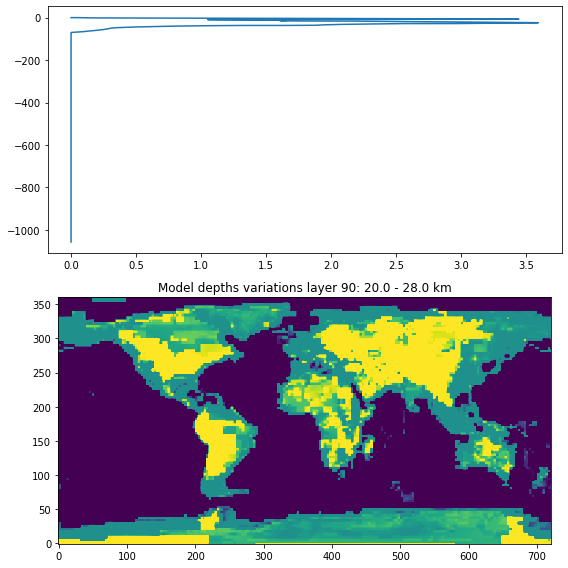

In [10]:
# Note that the uppermost 100 km have different depths 
depths_var = np.std(grid[:,:,:,2], axis=(0,1))

fig, ax = plt.subplots(2,1, figsize = (8,8))

ax[0].plot(depths_var, -grid[0,0,:,2])

print('Consistant depths:', (depths_var!=0).argmax(axis=0))

ex_layer = 90
d_layer = grid[:,:,ex_layer,2]
ax[1].set_title('Model depths variations layer %s: %s - %s km'%(ex_layer, np.min(d_layer), np.max(d_layer)))
ax[1].imshow(d_layer, origin='lower')
plt.tight_layout()

# Thsi could easlit be interpolated, if a regular grid of the crust is needed

In [11]:
# For now, we convert the regular grid to xarray dataset
lons_v, lats_v = np.meshgrid(lons, lats) 

# Get lat lon chords from file
SL2013sv=xr.Dataset( coords={'lon': (['x', 'y'], lons_v),
                    'lat': (['x', 'y'], lats_v),
                    'depth': (['z'], range(0,np.shape(grid)[2])),
                    'model_depth' : (['x', 'y', 'z'], grid[:,:,:,2]),
                    })

# Get meta data, as provided by authors
with open('../data/SL2013sv_1D_0.5D/README', 'r') as content_file:
    content = content_file.read()

SL2013sv.attrs['description'] = content

# Assign data to xarray dataset
SL2013sv["vs"]=(['x', 'y', 'model_depth'],  grid[:,:,:,0])
SL2013sv["vp"]=(['x', 'y', 'model_depth'],  grid[:,:,:,1])

We can now save the dataset as netcdf, a multipurpuse file format.There are a number of options that are decsribed [here](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.to_netcdf.html). 

Read more abourt netCDF [here](https://www.unidata.ucar.edu/software/netcdf/docs/faq.html#What-Is-netCDF). 

In [12]:
SL2013sv.to_netcdf(path='SL2013.nc', mode='w') 

# You'll get a Permission denied if teh file is in use etc.

We now get a much smaller and faster file, with named coordinates, and metadata attached. 

In [13]:
! stat SL2013.nc

16777221 15454109 -rw-r--r-- 1 tobias_stal staff 0 760037834 "May  5 13:01:08 2020" "May  5 14:03:54 2020" "May  5 14:03:54 2020" "May  5 13:01:06 2020" 4096 1484456 0 SL2013.nc


In [14]:
# now it loads quicker:
SL2013sv = None

SL2013sv = xr.open_dataset('SL2013.nc')

print(SL2013sv)
print(SL2013sv.attrs['description'])

<xarray.Dataset>
Dimensions:      (model_depth: 121, x: 361, y: 721, z: 121)
Coordinates:
    lon          (x, y) float64 ...
    lat          (x, y) float64 ...
    depth        (z) int64 ...
    model_depth  (x, y, z) float64 ...
Dimensions without coordinates: x, y, z
Data variables:
    vs           (x, y, model_depth) float64 ...
    vp           (x, y, model_depth) float64 ...
Attributes:
    description:  Mar 2018, AJS\n\nTwo versions of 3D Absolute velocity SL201...
Mar 2018, AJS

Two versions of 3D Absolute velocity SL2013sv. Laterally the two models
are gridded at 0.5 Degrees, with a 1D profile extraced at each
grid location. The grid points are located in the file 0.5DGrid.ll.

Both model files use a ">" character to delimit separate models. This is
the same default convention as GMT uses in multi-segment files.
These files are further gzipped to reduce their disk usage.

The vertical profiles are appropriately formatted for use with MINEOS. The 
model perturbations between 

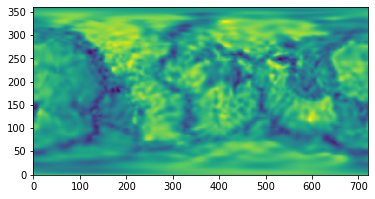

In [15]:
#Simple plot frm matplotlib
plt.imshow(SL2013sv['vs'].sel(model_depth=62), origin='lower')

## Discussion and conclusion

This workflow might not be optimal, but provide an example of how tricky file formats can be imported to numpy, using standard packages, and how the data can be stored in a more convenient format. More advanced processing and visualisation is availibe from e.g. agrid [Stål and Reading (2020)](https://doi.org/10.5334/jors.287).


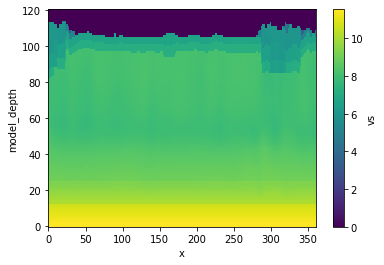

In [16]:
SL2013sv['vs'].isel(y=30).T.plot()

## References: 

Hoyer, S., & Hamman, J. J. (2017). xarray: N-D labeled Arrays and Datasets in Python. Journal of Open Research Software, 5(1), 1–6. https://doi.org/10.5334/jors.148

Schaeffer, A. J., & Lebedev, S. (2013). Global shear speed structure of the upper mantle and transition zone. Geophysical Journal International, 194(1), 417–449. https://doi.org/10.1093/gji/ggt095

Stål, T., & Reading, A. M. (2020). A Grid for Multidimensional and Multivariate Spatial Representation and Data Processing. Journal of Open Research Software, 8. https://doi.org/10.5334/jors.287

van der Walt, S., Colbert, S. C., & Varoquaux, G. (2011). The NumPy array: A structure for efficient numerical computation. Computing in Science and Engineering, 13(2), 22–30. https://doi.org/10.1109/MCSE.2011.37